In [23]:
import os
import re
import yaml
import json
import pprint
import tifffile
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

from src import measures
from src.separator import Separator
from src.cleaner import DoubleStepCleaner

In [27]:
main_organ = 'heartkidney'
fpath = "/mnt/HD-LSDF/Medaka/201912_beamtime_medaka/"
cfg_path = f"/home/ws/er5241/Repos/measuring-repo/measurement_configs/measurement/{main_organ}.yaml"
db_path = "/home/ws/er5241/Repos/measuring-repo/artifacts/debug.json"

In [34]:
fls = os.listdir(fpath)
id = np.random.choice(fls)

# id = 'Medaka_508_33-1'
img_path = fpath + id + "/scaled_0.5_8bit_cropped_slices.tif"
msk_path = fpath + id + f"/{main_organ}_scaled_0.5_8bit_cropped_slices.tif"

print(id)

Medaka_1384_134-1


In [35]:
img = tifffile.imread(img_path)
msk = tifffile.imread(msk_path)

In [ ]:
def plot_max(img, msk):
    for ax in range(3):
        img_swap, msk_swap = img.swapaxes(0,ax), msk.swapaxes(0,ax)
        if ax==1:
            img_swap, msk_swap = img_swap.swapaxes(1,2), msk_swap.swapaxes(1,2)
        print(img_swap.shape)
        plt.figure(figsize=(15, 15))
        plt.imshow(np.max(img_swap, axis=0), cmap='gray')
        plt.imshow(np.max(msk_swap, axis=0), cmap='tab10', alpha=(np.max(msk_swap, axis=0)>0)*0.7)
        plt.show()

plot_max(img, msk)

(2208, 608, 768)
[0 0 0]
1698


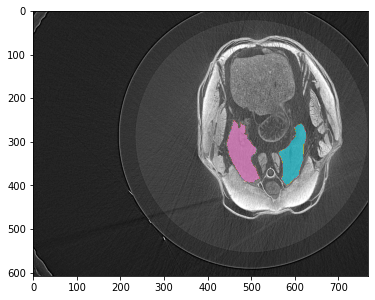

In [36]:
 def plot_slice(img, msk):
    ne_slc = np.where(msk.sum((1, 2))>0)[0]
    slice_id = ne_slc[len(ne_slc)//2]
    slice_id = np.argmax(msk.sum((1, 2)))

    print(msk.shape)
    print(np.array(msk.shape) - np.array(img.shape))
    print(slice_id)

    plt.figure(figsize=(6, 6))
    plt.imshow(img[slice_id], cmap='gray')
    plt.imshow(msk[slice_id], cmap='tab10', alpha=(msk[slice_id]>0)*0.7)
    plt.show()

plot_slice(img, msk)

In [37]:
with open(cfg_path, "r") as stream:
    configs = yaml.safe_load(stream)

cleaning_config = configs['cleaning']
pprint.pprint(cleaning_config)

{'bbox_cleaning_type': '1d',
 'bounding_boxes': 2,
 'connected_areas_per_label': [{'connected_regions': 1, 'id': 1},
                               {'connected_regions': 1, 'id': 2},
                               {'connected_regions': 1, 'id': 3},
                               {'connected_regions': 1, 'id': 4},
                               {'connected_regions': 1, 'id': 5},
                               {'connected_regions': 1, 'id': 6}]}


In [38]:
cleaner = DoubleStepCleaner(**cleaning_config)

In [39]:
msk_clean, roi = cleaner(msk)
img_clean = img[roi]

print(roi)
print(msk_clean.shape)

(slice(1480, 1950, None), slice(85, 427, None), slice(442, 631, None))
(470, 342, 189)


In [40]:
counts, vals = np.unique(msk_clean, return_counts=True)
for c,v in zip(counts,vals):  print(c,':',v)

0 : 29075763
1 : 5595
2 : 255603
3 : 18086
4 : 386138
5 : 355752
6 : 282923


(470, 342, 189)
[0 0 0]
218


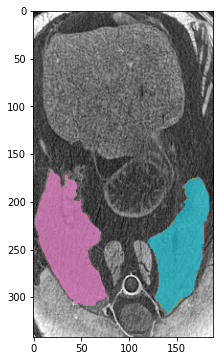

In [41]:
plot_slice(img_clean, msk_clean)

In [ ]:
plot_max(img_clean, msk_clean)

In [42]:
centering_config = configs['centering'] if 'centering' in configs else []
pprint.pprint(centering_config)

centers = {}
for centering in centering_config:
    centers[centering['name']] = Separator((msk_clean == centering['label_id']), centering['function'], centering['count'])

print(centers)

[]
{}


In [43]:
measuring_config = configs['measures']
pprint.pprint(measuring_config)

[{'id': 2,
  'measures': [{'function': 'volume'},
               {'function': 'surface_area'},
               {'function': 'color_average'},
               {'function': 'color_std'},
               {'function': 'eccentricity_meridional'},
               {'function': 'eccentricity_equatorial'}],
  'name': 'atrium'},
 {'id': 4,
  'measures': [{'function': 'volume'},
               {'function': 'surface_area'},
               {'function': 'color_average'},
               {'function': 'color_std'},
               {'function': 'eccentricity_meridional'},
               {'function': 'eccentricity_equatorial'}],
  'name': 'left_kidney'},
 {'id': 5,
  'measures': [{'function': 'volume'},
               {'function': 'surface_area'},
               {'function': 'color_average'},
               {'function': 'color_std'},
               {'function': 'eccentricity_meridional'},
               {'function': 'eccentricity_equatorial'}],
  'name': 'ventricle'},
 {'id': 6,
  'measures': [{'function': 'v

In [49]:
for label in measuring_config:
    label_mask = (msk_clean == label['id'])
    print(label['id'])
    for measure in label['measures']:
        mf = getattr(measures, measure['function'])
        cc = centers[label['center']] if ('center' in label.keys()) else None
        measurement = mf(label_mask, img_clean, cc)
        print(measure['function'],measurement)

2
volume [255603]
surface_area [64399]
color_average [112.90843221714925]
color_std [24.332299778166096]
eccentricity_meridional [0.2752244555981815]
eccentricity_equatorial [0.14457540307894967]
4
volume [386138]
surface_area [107670]
color_average [126.65657614635182]
color_std [18.477554787839818]
eccentricity_meridional [0.4615081650071069]
eccentricity_equatorial [0.18448535444660355]
5
volume [355752]
surface_area [61948]
color_average [141.5362527828375]
color_std [19.484081989868926]
eccentricity_meridional [0.25181112034715425]
eccentricity_equatorial [0.1116551290160359]
6
volume [282923]
surface_area [61912]
color_average [133.38511891928192]
color_std [18.537678327742082]
eccentricity_meridional [0.42909588305299917]
eccentricity_equatorial [0.28310078500546937]


## Verify results

In [44]:
with open(cfg_path, "r") as stream:
    configs = yaml.safe_load(stream)

measuring_config = configs['measures']

In [45]:
meas_config = {}
for meas in measuring_config:
    meas_config[meas['name']] = [ m['function'] for m in meas['measures'] ]

pprint.pprint(meas_config)

{'atrium': ['volume',
            'surface_area',
            'color_average',
            'color_std',
            'eccentricity_meridional',
            'eccentricity_equatorial'],
 'left_kidney': ['volume',
                 'surface_area',
                 'color_average',
                 'color_std',
                 'eccentricity_meridional',
                 'eccentricity_equatorial'],
 'right_kidney': ['volume',
                  'surface_area',
                  'color_average',
                  'color_std',
                  'eccentricity_meridional',
                  'eccentricity_equatorial'],
 'ventricle': ['volume',
               'surface_area',
               'color_average',
               'color_std',
               'eccentricity_meridional',
               'eccentricity_equatorial']}


In [46]:
a_file = open(db_path, "r")
debug = json.load(a_file)
a_file.close()

debug = debug['_default']
keys = [str(i) for i in range(1,len(debug)+1)]

def in_nested_list(my_list):  # check for 0 or nan values
    if 0 in my_list or any([np.isnan(x).any() for x in my_list]):  return True
    else:  return any(in_nested_list(sublist) for sublist in my_list if isinstance(sublist, list))

passed_files = []
failed_files = []
fail_counts = {org : 0 for org in meas_config.keys()}
for directory in glob(f'{fpath}/Medaka_*_*/'):
    id = re.findall('/Medaka_(.*?)_.*/', directory)[0]
    debug_data = next((v for k,v in debug.items() if v['id']==id), [])
    
    if main_organ in debug_data:
        passed_files.append(id)
        main_organ_data = debug_data[main_organ]
        for sub_organ, organ_meas in main_organ_data.items():
            if set(organ_meas.keys()) != set(meas_config[sub_organ]):
                fail_counts[sub_organ] += 1
            elif in_nested_list(organ_meas.values()):
                fail_counts[sub_organ] += 1
    else:
        failed_files.append(id)

In [47]:
print(fail_counts)
print(len(failed_files))

{'atrium': 64, 'left_kidney': 54, 'ventricle': 56, 'right_kidney': 72}
54


In [48]:
lines = {}

for fl in failed_files:
    a = glob(f'{fpath}/*_{fl}*')[0]
    a = a[a.rindex('_')+1:]
    if a not in lines:
        lines[a] = 1
    else:    
        lines[a] += 1

lines = {k: v for k, v in sorted(lines.items(), key=lambda item: item[1], reverse=True)}
for k,v in lines.items():
    tot = len(glob(f'{fpath}/*{k}'))
    print(f'{k} \t{v}/{tot}')

unstained 	18/18
14-2 	6/8
eye 	3/4
131-4 	2/6
33-1 	2/8
84-2 	2/7
132-4 	2/6
13-2 	2/4
135-1 	2/6
140-3 	2/8
71-1 	2/4
25-1 	1/6
135-2 	1/5
139-4 	1/5
129-1 	1/7
55-2 	1/7
39-1 	1/7
110-2 	1/7
104-1 	1/6
117-1 	1/7
53-2 	1/7
70-2 	1/5
